In this lesson we will use NAIP data to create a GIF showing vegetation change over Campus Point at UCSB.

## Context
Campus Point has undergone multiple active restoration projects since 2005.

Most recently, to remove iceplant, which is an invasive succulent that competes with native plants and covers most of Campus Point.

Import libraries and functions.

To create the GIF we'll be using teh `geogif` library, which makes it simple to create a gif from an `xarray.DataArray`.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import pystac_client
import planetary_computer

from geogif import gif  # to create gif


## Data Search

In [4]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around campus point
bbox = [-119.84682486219316, 34.404860394049024, -119.84370917948988, 34.40632764289684]

# search 
search = catalog.search(
    collections=["naip"], 
    bbox=bbox, 
    datetime='2016/2023' # years with 0.6m/pixel resolution
)


In [5]:
# get items from search
items = search.item_collection()
print(len(items))

3


## Prepare a single raster

The NAIP data is available at the item's 'image' asset:

In [7]:
item = items[0]
sb = rioxr.open_rasterio(item.assets['image'].href)

sb

<xarray.DataArray (band: 4, y: 12500, x: 10580)>
[529000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.354e+05 2.354e+05 ... 2.418e+05 2.418e+05
  * y            (y) float64 3.815e+06 3.815e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

This raster is way bigger than our area of interest.

Let's verify this and then clip the raster.

We will need our bbox as a `GeoDataFrame`.

In [8]:
# bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='epsg:4326') 

box_df

,geometry
0,"POLYGON ((-119.84371 34.40486, -119.84371 34.4..."


<Axes: >

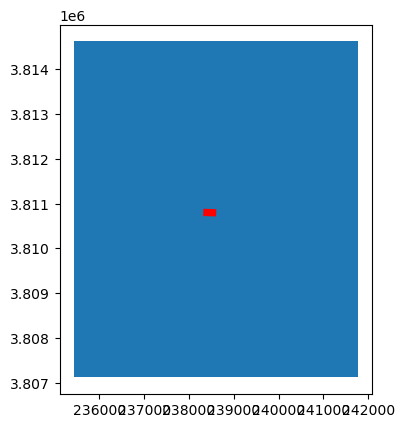

In [10]:
# plot bounding box and raster extents
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry = [box(*sb.rio.bounds())],
                 crs = sb.rio.crs).plot(ax = ax)

box_df.to_crs(sb.rio.crs).plot(ax = ax, color = 'red')

In [11]:
# clip raster to bounding box

sb = sb.rio.clip_box(*box_df.to_crs(sb.rio.crs).total_bounds)

sb

# box_df.to_crs(sb.rio.crs) <- this code reprojects crs
# .total_bounds <- extent of box
# * unpacking each number in list and passing it separately in the function

<xarray.DataArray (band: 4, y: 286, x: 486)>
[555984 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.383e+05 2.383e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

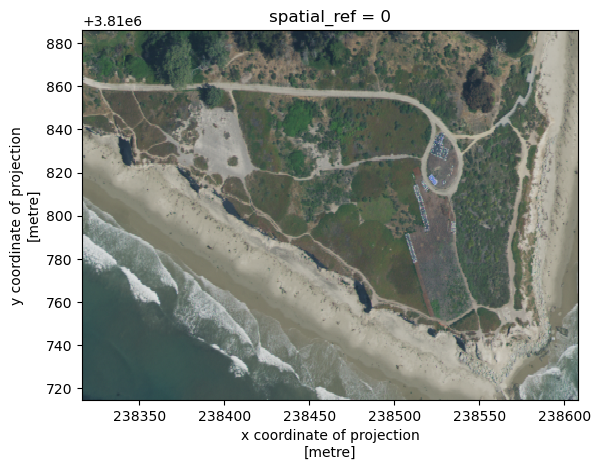

In [12]:
# select red, green, blue bands and plot true color image
sb = sb.sel(band = [1,2,3])
sb.plot.imshow()


## Stack rasters

The `gif` function indicates we need to put our images/rasters in a single `xarray.DataArray` with dimensions `(time, band, y, x)`.

A single raster has the following dimensions:

In [13]:
print('dimensions: ', sb.dims)
print('shape: ', sb.shape)

dimensions:  ('band', 'y', 'x')
shape:  (3, 286, 486)


To create a single `xarray.DataArray` with a time dimension we will stack the three rasters obtained in our search.

We use `for` loop to:
1. access the item's `image` asset
2. clip raster
3. select bands, 
and store each processed raster in a list.

In [14]:
# create a list with rasters
rasters = []
for item in items:
    sb = rioxr.open_rasterio(item.assets['image'].href) # load raster
    sb = sb.rio.clip_box(*box_df.to_crs(sb.rio.crs).total_bounds) # clip raster
    sb = sb.sel(band=[1,2,3]) # select RGB bands
    rasters.append(sb)

Use `xarray.concat()` to concatenate these rasters along a new dimension we will call `time`

In [15]:
# concatenate rasters into single xarray.DataArray
stack = xr.concat(rasters, dim='time')
stack

<xarray.DataArray (time: 3, band: 3, y: 286, x: 486)>
array([[[[ 96, 109,  96, ..., 133, 147, 148],
         [108,  99,  87, ..., 134, 145, 150],
         [110, 109, 101, ..., 123, 142, 150],
         ...,
         [ 37,  37,  37, ..., 150, 130, 158],
         [ 36,  38,  37, ..., 158, 135, 137],
         [ 37,  38,  38, ..., 151, 145, 116]],

        [[105, 112, 107, ..., 130, 146, 146],
         [113, 106,  94, ..., 136, 142, 147],
         [113, 109, 107, ..., 128, 141, 148],
         ...,
         [ 58,  59,  60, ..., 161, 153, 167],
         [ 56,  58,  59, ..., 173, 156, 158],
         [ 58,  58,  59, ..., 166, 157, 137]],

        [[ 93, 105,  99, ..., 121, 130, 128],
         [ 88,  88,  85, ..., 120, 128, 131],
         [ 87,  86,  84, ..., 113, 127, 133],
         ...,
...
         ...,
         [ 45,  46,  39, ...,  61,  64,  59],
         [ 57,  64,  36, ...,  63,  55,  53],
         [ 53,  57,  40, ...,  55,  50,  46]],

        [[ 48,  46,  49, ...,  90,  90,  99],
         [ 48,  47,  49, ...,  88,  92, 120],
         [ 54,  49,  49, ...,  85, 112, 114],
         ...,
         [ 58,  58,  57, ...,  70,  76,  74],
         [ 73,  70,  53, ...,  76,  70,  66],
         [ 65,  69,  52, ...,  68,  59,  60]],

        [[ 51,  51,  53, ...,  85,  86, 109],
         [ 52,  52,  53, ...,  85,  99, 119],
         [ 54,  51,  55, ...,  81, 109, 108],
         ...,
         [ 70,  68,  62, ...,  79,  79,  76],
         [ 78,  75,  61, ...,  81,  72,  70],
         [ 71,  77,  63, ...,  74,  66,  65]]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.383e+05 2.383e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Dimensions without coordinates: time
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

Notice `time` does not have any coordinates associated to it. 

Let's add them.

We will use the year of collection of eaach raster as its coordinate in the `time` dimensions.

In [16]:
# year of collection of an item
item = items[0]
item.properties['naip:year']

'2020'

In [19]:
# convert strings to datetime
pd.to_datetime(item.properties['naip:year'])

Timestamp('2020-01-01 00:00:00')

In [20]:
times = []
for item in items:
    times.append(pd.to_datetime(item.properties['naip:year']))

times

# in one line:
# times = [pd.to_datetime(item.properties['naip:year']) for item in items]

[Timestamp('2020-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

Finally, we assign these times as teh coordinates and sort by the values of the time dimension:

In [21]:
stack = stack.assign_coords(time = times).sortby('time')
stack

<xarray.DataArray (time: 3, band: 3, y: 286, x: 486)>
array([[[[ 51,  48,  49, ...,  98,  96, 114],
         [ 54,  49,  52, ...,  96,  96, 122],
         [ 59,  51,  55, ...,  90, 119, 112],
         ...,
         [ 45,  46,  39, ...,  61,  64,  59],
         [ 57,  64,  36, ...,  63,  55,  53],
         [ 53,  57,  40, ...,  55,  50,  46]],

        [[ 48,  46,  49, ...,  90,  90,  99],
         [ 48,  47,  49, ...,  88,  92, 120],
         [ 54,  49,  49, ...,  85, 112, 114],
         ...,
         [ 58,  58,  57, ...,  70,  76,  74],
         [ 73,  70,  53, ...,  76,  70,  66],
         [ 65,  69,  52, ...,  68,  59,  60]],

        [[ 51,  51,  53, ...,  85,  86, 109],
         [ 52,  52,  53, ...,  85,  99, 119],
         [ 54,  51,  55, ...,  81, 109, 108],
         ...,
...
         ...,
         [ 37,  37,  37, ..., 150, 130, 158],
         [ 36,  38,  37, ..., 158, 135, 137],
         [ 37,  38,  38, ..., 151, 145, 116]],

        [[105, 112, 107, ..., 130, 146, 146],
         [113, 106,  94, ..., 136, 142, 147],
         [113, 109, 107, ..., 128, 141, 148],
         ...,
         [ 58,  59,  60, ..., 161, 153, 167],
         [ 56,  58,  59, ..., 173, 156, 158],
         [ 58,  58,  59, ..., 166, 157, 137]],

        [[ 93, 105,  99, ..., 121, 130, 128],
         [ 88,  88,  85, ..., 120, 128, 131],
         [ 87,  86,  84, ..., 113, 127, 133],
         ...,
         [ 69,  69,  70, ..., 155, 148, 161],
         [ 67,  69,  70, ..., 169, 151, 152],
         [ 69,  70,  68, ..., 166, 156, 135]]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.383e+05 2.383e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2016-01-01 2018-01-01 2020-01-01
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

In [25]:
# create gif
gif(stack, fps = 1, to = 'campus_point.gif')